In [1]:
# Import the required libraries.
# Optuna for hyperparameter optimization, TensorFlow for building the neural network model, and other supporting libraries.
!pip install optuna
!pip install seaborn
import optuna
import tensorflow as tf
import time
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Reduce dataset size
x_train, x_test = x_train[:10000], x_test[:2000]
y_train, y_test = y_train[:10000], y_test[:2000]

# Split data into training and temporary set
x_train, x_temp, y_train, y_temp = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

# Split temporary set into validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

best_train_losses = []
best_train_accuracies = []
best_val_losses = []
best_val_accuracies = []
best_test_losses = []
best_test_accuracies = []

# Start recording time for benchmarking purposes.
start_time = time.time()

# Initialize lists to store various loss and accuracy values during training and evaluation.
best_train_losses = []
best_train_accuracies = []
best_val_losses = []
best_val_accuracies = []
best_test_losses = []
best_test_accuracies = []
global_best_accuracy = 0

# Define a function to create a model. The architecture of the model is determined by the hyperparameters selected by Optuna
def create_model(trial):
    global best_train_losses
    global best_train_accuracies
    global best_val_losses
    global best_val_accuracies
    global best_test_losses
    global best_test_accuracies
    global global_best_accuracy
    
    # Optuna explores different numbers of convolutional layers, filter sizes, dropout rates, optimizers, learning rates, activation functions, and regularization strengths.
    num_conv_layers = trial.suggest_int('num_conv_layers', 2, 5)
    num_filters = trial.suggest_categorical('num_filters', [32, 64, 128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.7)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop', 'adagrad'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-2)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'elu'])
    reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1e-1)

    # Build the convolutional layers based on the selected hyperparameters.
    model = tf.keras.models.Sequential()

    for i in range(num_conv_layers):
        if i == 0:
            model.add(tf.keras.layers.Conv2D(num_filters, (3, 3), activation=activation, input_shape=(32, 32, 3), kernel_regularizer=l2(reg_lambda), padding='same'))
        else:
            model.add(tf.keras.layers.Conv2D(num_filters, (3, 3), activation=activation, kernel_regularizer=l2(reg_lambda), padding='same'))
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation=activation, kernel_regularizer=l2(reg_lambda)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=l2(reg_lambda)))

    # Compile the model with the selected optimizer and loss function for a multi-class classification problem.
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the objective function for the Optuna study.
def objective(trial):
    epochs = trial.suggest_int('epochs', 1, 50)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    model = create_model(trial)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    test_losses = []
    test_accuracies = []

    # Train the model for each epoch and evaluate it on the validation and test sets
    for epoch in range(epochs):
        history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1, batch_size=batch_size, verbose=0, callbacks=[early_stopping])
        
        train_losses.extend(history.history['loss'])
        train_accuracies.extend(history.history['accuracy'])
        val_losses.extend(history.history['val_loss'])
        val_accuracies.extend(history.history['val_accuracy'])
        
        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    global best_train_losses, best_train_accuracies, best_val_losses, best_val_accuracies, best_test_losses, best_test_accuracies
    best_train_losses = train_losses
    best_train_accuracies = train_accuracies
    best_val_losses = val_losses
    best_val_accuracies = val_accuracies
    best_test_losses = test_losses
    best_test_accuracies = test_accuracies

    return val_accuracies[-1]  # returning the last validation accuracy

# Create an Optuna study object and specify the direction is 'maximize' to find hyperparameters that result in maximum accuracy.
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())

# Perform optimization with the objective function for 30 trials.
study.optimize(objective, n_trials=30)

# Output the results of the hyperparameter optimization process.
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)
print("Params: ", trial.params)

# Retrain the model using the best hyperparameters found by Optuna.
best_params = trial.params

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

best_model = create_model(optuna.trial.FixedTrial(best_params))

final_history = best_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1, callbacks=[early_stopping])

final_test_loss, final_test_accuracy = best_model.evaluate(x_test, y_test, verbose=1)
print("Final Test loss: ", final_test_loss)
print("Final Test accuracy: ", final_test_accuracy)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


170498071/170498071 [==============================] - 2s 0us/step


[I 2023-10-12 13:29:46,358] A new study created in memory with name: no-name-9574f1f2-55e6-46d1-b758-7d394753e882
/tmp/ipykernel_28/1699588922.py:65: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-2)
[I 2023-10-12 13:30:20,558] Trial 0 finished with value: 0.195333331823349 and parameters: {'epochs': 5, 'batch_size': 128, 'num_conv_layers': 4, 'num_filters': 128, 'dropout_rate': 0.37036697459983614, 'optimizer': 'adagrad', 'learning_rate': 6.327588559088871e-05, 'activation': 'elu', 'reg_lambda': 0.0657751492140566}. Best is trial 0 with value: 0.195333331823349.
[I 2023-10-12 13:31:16,256] Trial 1 finished with value: 0.3553333282470703 and parameters: {'epochs': 34, 'batch_size': 32, 'num_conv_layers': 2, 'num_filters': 32, 'dropout_rate': 0.6624263626797761, '

Number of finished trials:  30
Best trial:
Value:  0.3553333282470703
Params:  {'epochs': 34, 'batch_size': 32, 'num_conv_layers': 2, 'num_filters': 32, 'dropout_rate': 0.6624263626797761, 'optimizer': 'adagrad', 'learning_rate': 0.006225729731380232, 'activation': 'tanh', 'reg_lambda': 0.045010775753143065}
Epoch 1/34
219/219 [==============================] - 2s 5ms/step - loss: 9.9228 - accuracy: 0.1310 - val_loss: 9.4366 - val_accuracy: 0.1880
Epoch 2/34
219/219 [==============================] - 1s 5ms/step - loss: 9.0592 - accuracy: 0.1741 - val_loss: 8.6805 - val_accuracy: 0.2267
Epoch 3/34
219/219 [==============================] - 1s 5ms/step - loss: 8.3621 - accuracy: 0.2149 - val_loss: 8.0342 - val_accuracy: 0.2767
Epoch 4/34
219/219 [==============================] - 1s 5ms/step - loss: 7.7669 - accuracy: 0.2311 - val_loss: 7.4820 - val_accuracy: 0.2933
Epoch 5/34
219/219 [==============================] - 1s 5ms/step - loss: 7.2528 - accuracy: 0.2553 - val_loss: 7.0039 - v

In [2]:
# Print time taken by the code to run
end_time = time.time()
print("Time taken by the code to run: ", end_time - start_time, " seconds")

Time taken by the code to run:  1748.8788137435913  seconds


In [3]:
# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=1)
print("Test loss: ", test_loss)
print("Test accuracy: ", test_acc)

47/47 [==============================] - 0s 3ms/step - loss: 3.0360 - accuracy: 0.3227
Test loss:  3.0359609127044678
Test accuracy:  0.3226666748523712


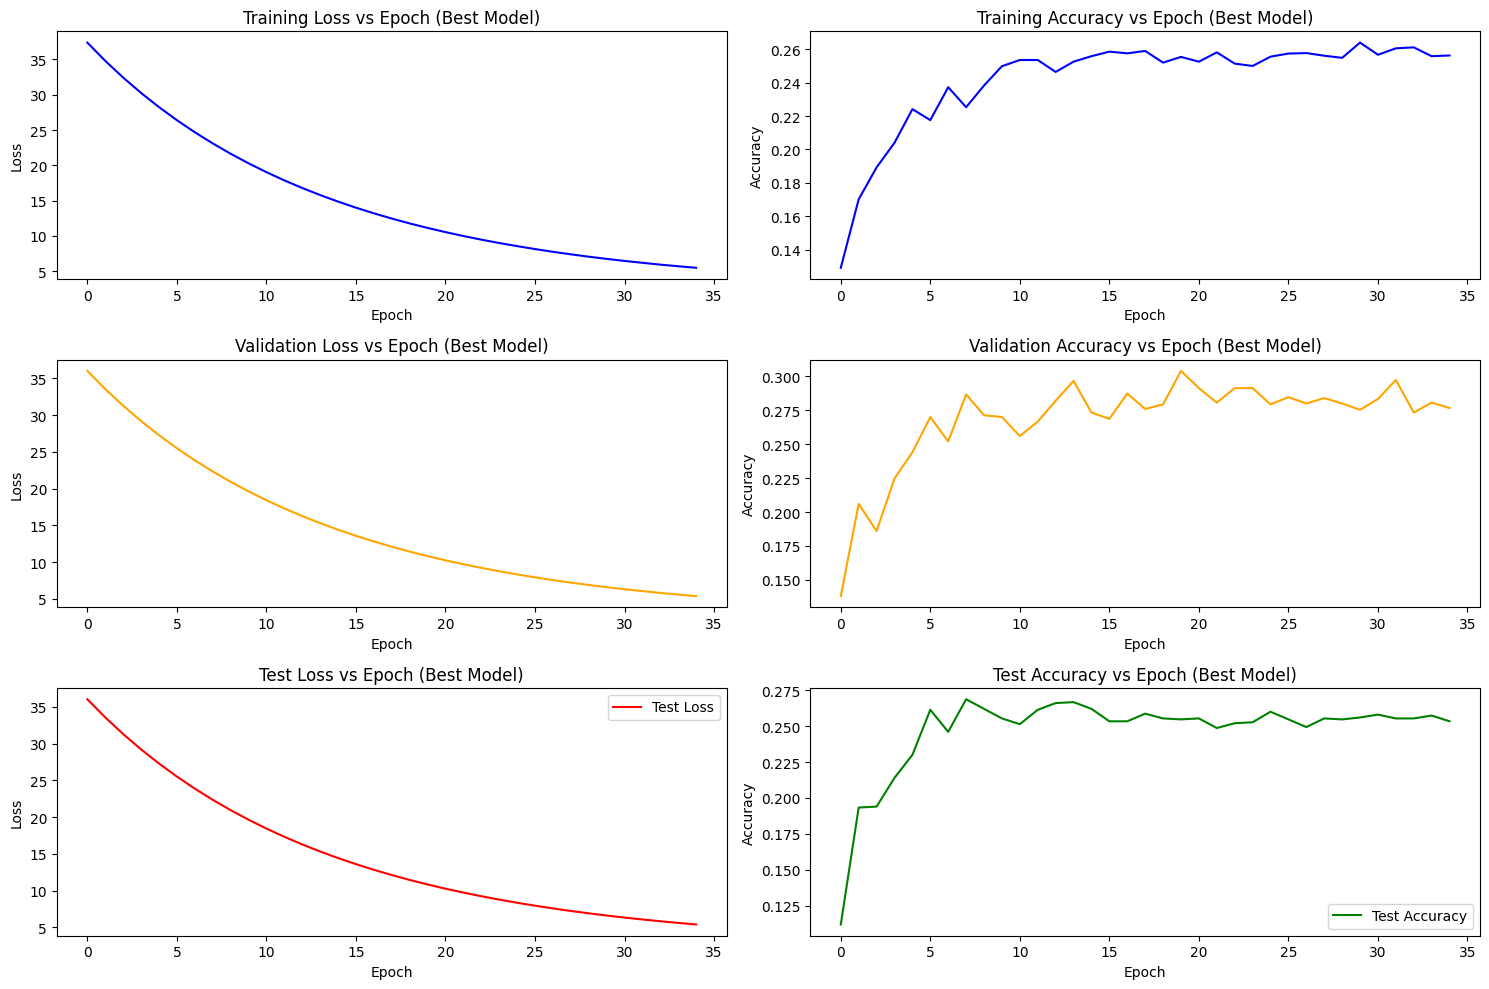

In [5]:
# Plotting
plt.figure(figsize=(15, 10))

# Training Loss vs Epoch
plt.subplot(3, 2, 1)
plt.plot(best_train_losses, label='Training Loss', color='blue')
plt.title('Training Loss vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Training Accuracy vs Epoch
plt.subplot(3, 2, 2)
plt.plot(best_train_accuracies, label='Training Accuracy', color='blue')
plt.title('Training Accuracy vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Validation Loss vs Epoch
plt.subplot(3, 2, 3)
plt.plot(best_val_losses, label='Validation Loss', color='orange')  
plt.title('Validation Loss vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Validation Accuracy vs Epoch
plt.subplot(3, 2, 4)
plt.plot(best_val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Validation Accuracy vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Test Loss vs Epoch for Best Test Loss
plt.subplot(3, 2, 5)
plt.plot(best_test_losses, label='Test Loss', color='red')
plt.title('Test Loss vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Test Accuracy vs Epoch for Best Test Accuracy
plt.subplot(3, 2, 6)
plt.plot(best_test_accuracies, label='Test Accuracy', color='green')
plt.title('Test Accuracy vs Epoch (Best Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

47/47 [==============================] - 0s 2ms/step


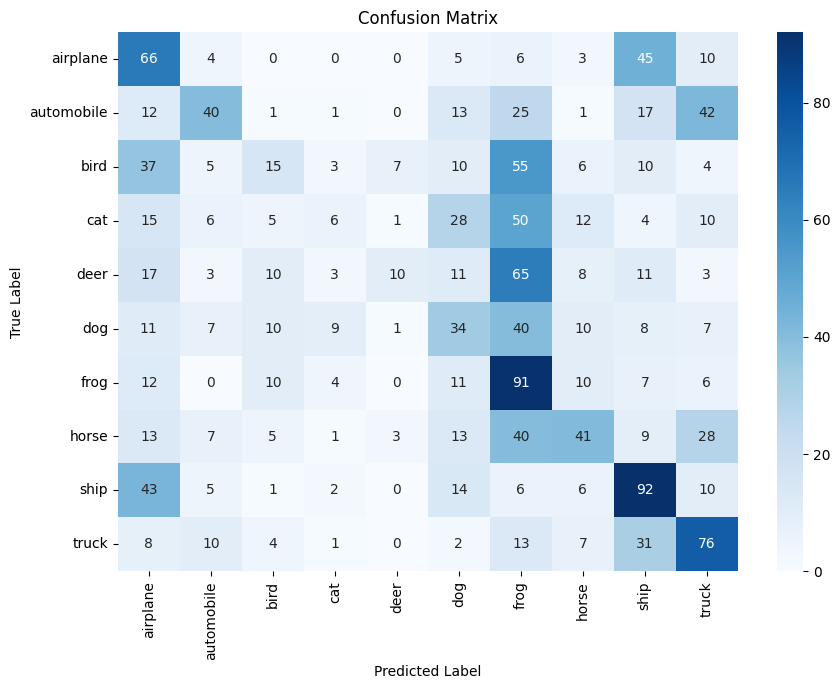

In [6]:
# Class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get model predictions
y_pred_probabilities = best_model.predict(x_test)

# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred_probabilities, axis=1) 

# Convert validation observations to one hot vectors
y_true = y_test.squeeze()

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [7]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Calculate precision, recall, and f1-score for each class
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

# If you want to access precision, recall, and f1-score values separately, you can do it as follows:
precision_recall_f1 = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

# Extract precision, recall, and f1-score for each class
for class_name in class_names:
    precision = precision_recall_f1[class_name]['precision']
    recall = precision_recall_f1[class_name]['recall']
    f1_score = precision_recall_f1[class_name]['f1-score']
    print(f"For class {class_name}:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1_score:.2f}")
    print("---")


              precision    recall  f1-score   support

    airplane       0.28      0.47      0.35       139
  automobile       0.46      0.26      0.33       152
        bird       0.25      0.10      0.14       152
         cat       0.20      0.04      0.07       137
        deer       0.45      0.07      0.12       141
         dog       0.24      0.25      0.24       137
        frog       0.23      0.60      0.34       151
       horse       0.39      0.26      0.31       160
        ship       0.39      0.51      0.45       179
       truck       0.39      0.50      0.44       152

    accuracy                           0.31      1500
   macro avg       0.33      0.31      0.28      1500
weighted avg       0.33      0.31      0.29      1500

For class airplane:
Precision: 0.28
Recall: 0.47
F1-score: 0.35
---
For class automobile:
Precision: 0.46
Recall: 0.26
F1-score: 0.33
---
For class bird:
Precision: 0.25
Recall: 0.10
F1-score: 0.14
---
For class cat:
Precision: 0.20
Recall: 